### Train ChoiceNet with Boston housing dataset

In [1]:
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
from cn_reg_class import cn_reg_class
from sklearn.datasets import load_boston
from util import nzr,get_train_test_datasets,gpusession
print ("Packages loaded")

Packages loaded


### Test with different outlier rates

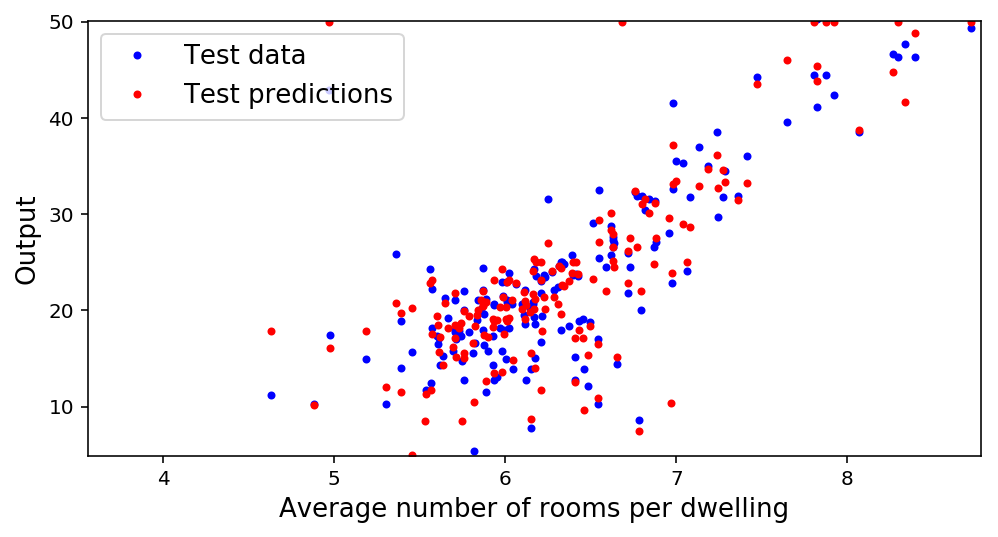

outlier rate:[0.0] rmse:[2.8155]


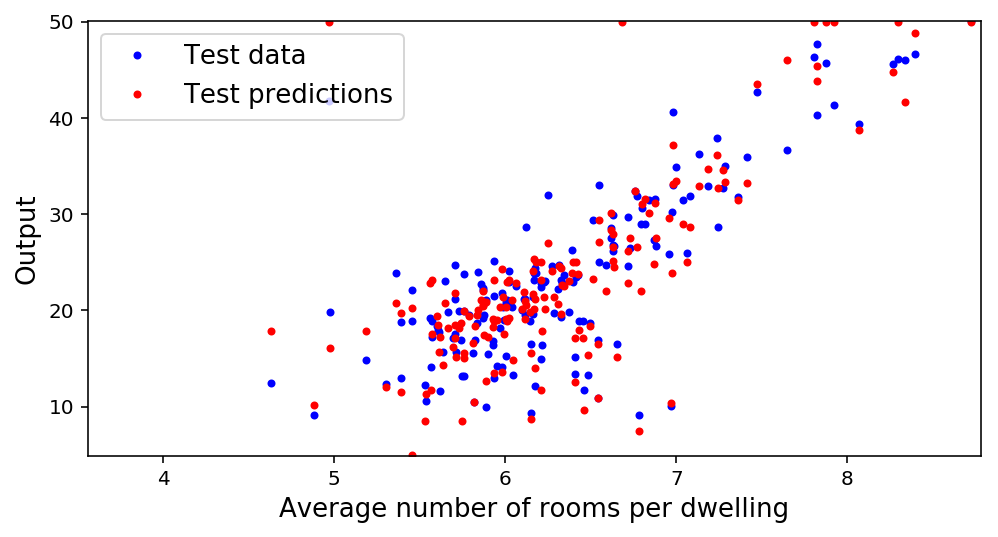

outlier rate:[0.1] rmse:[3.0892]


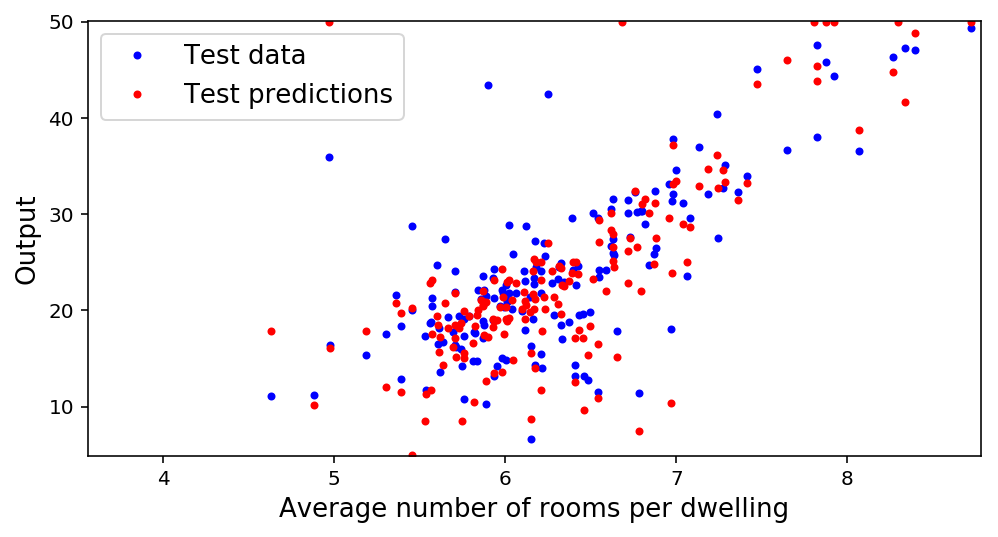

outlier rate:[0.1] rmse:[4.8606]


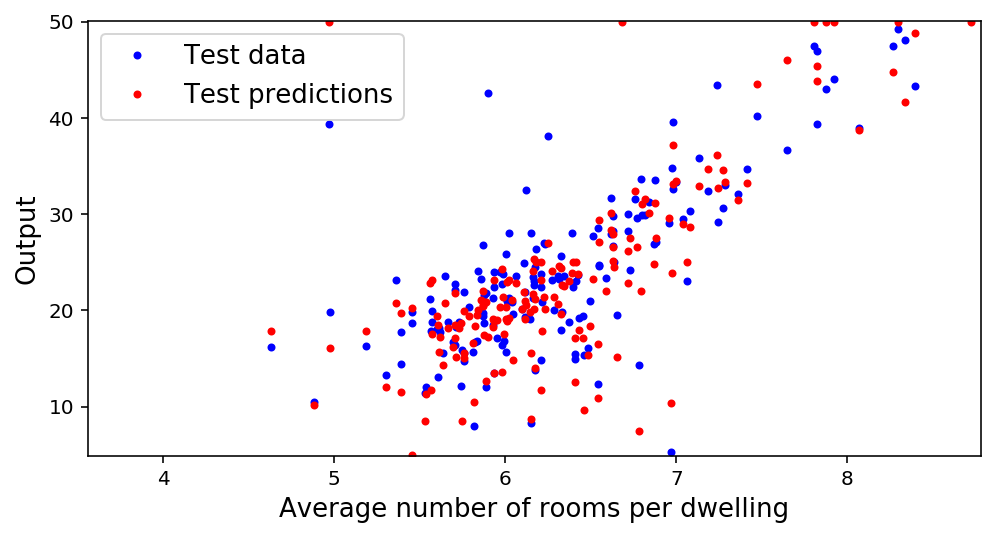

outlier rate:[0.1] rmse:[4.4245]


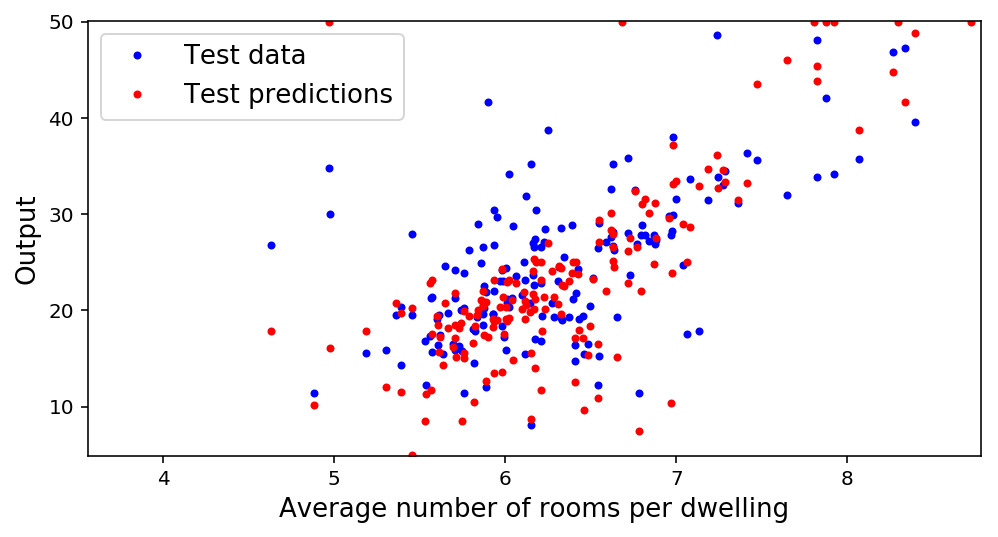

outlier rate:[0.2] rmse:[6.3702]


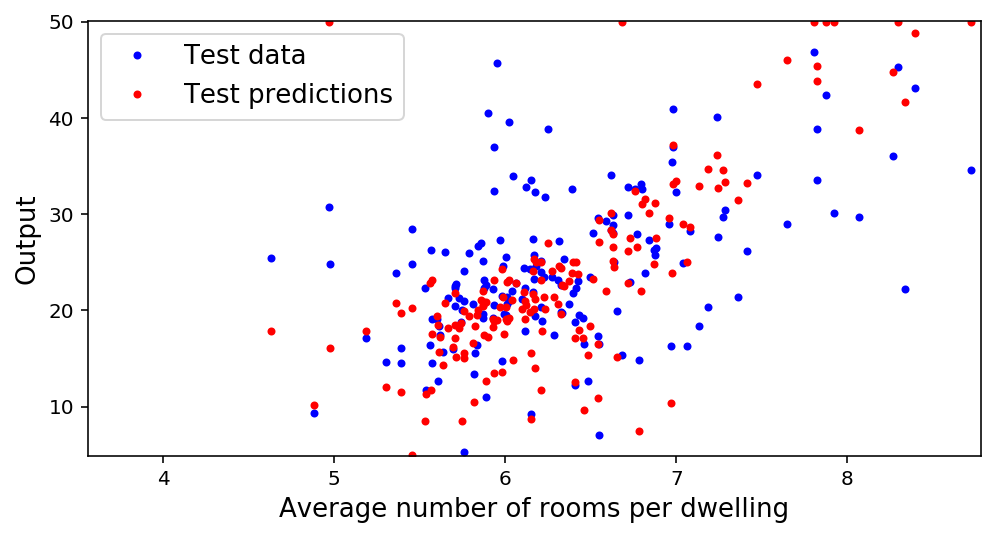

outlier rate:[0.3] rmse:[8.3985]


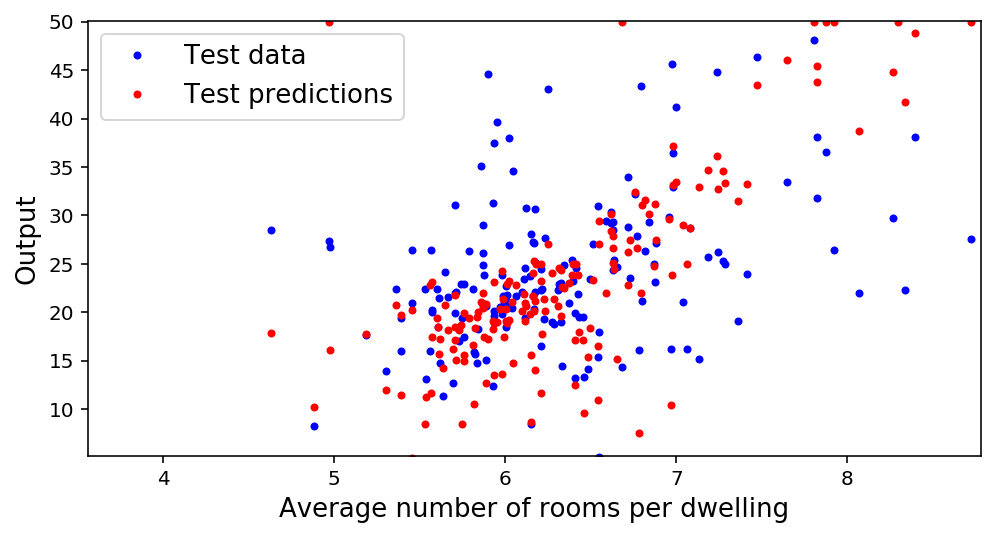

outlier rate:[0.4] rmse:[9.2212]


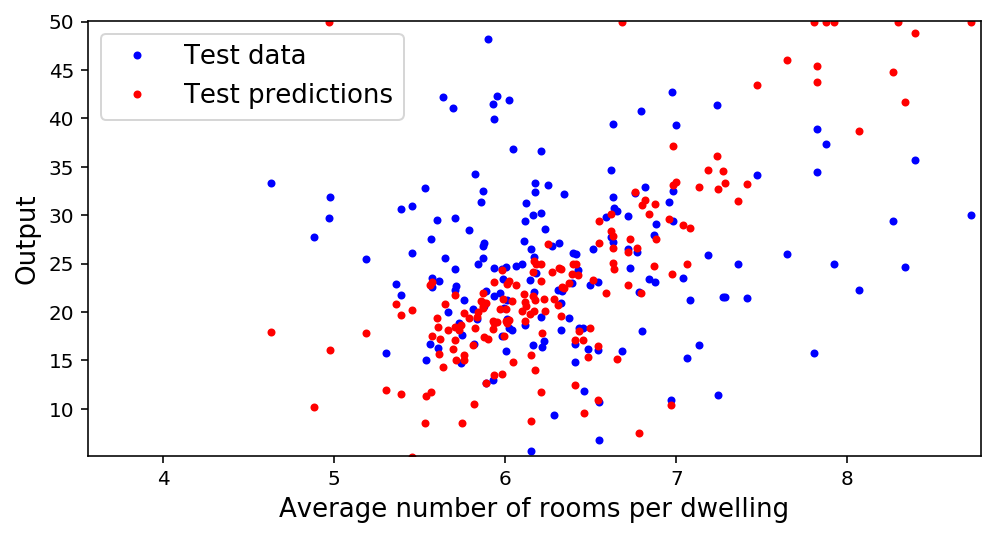

outlier rate:[0.5] rmse:[11.5646]
Done.


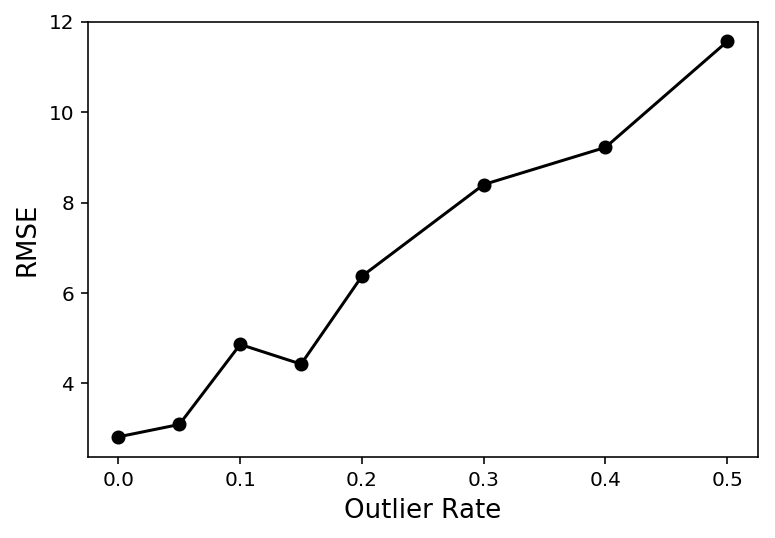

In [2]:
rseed = 1
dataset,dataset_name = load_boston(),'boston' # select dataset to use
outlier_rates = [0,0.05,0.1,0.15,0.2,0.3,0.4,0.5]
rmses = []
for outlier_rate in outlier_rates: # with different outlier rates
    x_train,x_test,y_train,y_test = get_train_test_datasets(
        dataset,dataset_name,_test_size=0.333,_outlier_rate=outlier_rate,
        _seed=rseed,_SAVE_MAT=False,_VERBOSE=False) # get training data with outliers
    tf.reset_default_graph(); sess = gpusession()
    tf.set_random_seed(rseed); np.random.seed(rseed) # fix seeds
    CN = cn_reg_class(_name='cn_%s'%(dataset_name),_x_dim=np.shape(x_train)[1],_y_dim=1,
                      _h_dims=[256,128],_k_mix=10,_actv=tf.nn.relu,_bn=slim.batch_norm,
                      _rho_ref_train=0.95,_tau_inv=1e-4,_var_eps=1e-2,
                      _pi1_bias=0.0,_log_sigma_Z_val=-2,
                      _kl_reg_coef=1e-6,_l2_reg_coef=1e-3,
                      _SCHEDULE_MDN_REG=0,_GPU_ID=1,_VERBOSE=0)
    sess.run(tf.global_variables_initializer()) # initialize variables
    CN.train(_sess=sess,_x_train=x_train,_y_train=y_train,
             _lr=1e-3,_batch_size=256,_max_epoch=1e4,_kp=1.0,
             _LR_SCHEDULE=1,_PRINT_EVERY=0,_PLOT_EVERY=0,
             _SAVE_TXT=0,_SAVE_BEST_NET=0,_SAVE_FINAL=0,_REMOVE_PREVS=0) # train
    rmse = CN.test(_sess=sess,_x_train=x_train,_y_train=y_train,_x_test=x_test,_y_test=y_test,
                   _PLOT_TRAIN=0,_PLOT_TEST=1,_SAVE_FIG=0,
                   _title_str4data='Outlier rate:[%.1f]'%(outlier_rate),
                   _x_dim4plot=5,_x_name4plot='Average number of rooms per dwelling') # test
    rmses.append(rmse) # collect rmse
    print ("outlier rate:[%.2f] rmse:[%.4f]"%(outlier_rate,rmse))
print ("Done.")
# Plot overall RMSE vs. outlier rate
plt.plot(outlier_rates,rmses,'ko-')
plt.xlabel('Outlier Rate',fontsize=13)
plt.ylabel('RMSE',fontsize=13)
plt.show()